# 事件研究法

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats


In [116]:
sns.set_palette("Set2")
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [117]:
events = ['2021-01-28','2021-05-09']

In [118]:
p1 = "含比特币的加密货币市值.xlsx"
p2 = "狗狗币.xlsx"

In [119]:
df_index = pd.read_excel(p1)
df = pd.read_excel(p2)

In [120]:
df_index = df_index[['Date', 'pct_chg']].copy()
df_index.columns = ['trade_date', '数字货币市场收益率']

In [121]:
df = df[['Date', '收益率']].copy()
df.columns = ['trade_date', '狗狗币收益率']

In [122]:
df_final = df.merge(df_index, on='trade_date', how='left')

In [123]:
df_final

,trade_date,狗狗币收益率,数字货币市场收益率
0,2020-08-23,NaN,NaN
1,2020-08-24,0.003441,0.012078
2,2020-08-25,-0.030442,-0.026528
3,2020-08-26,-0.008612,-0.003059
4,2020-08-27,-0.019634,-0.008055
...,...,...,...
295,2021-06-14,0.031395,0.057080
296,2021-06-15,-0.016339,0.011552
297,2021-06-16,-0.032352,-0.032510
298,2021-06-17,-0.015733,-0.017551


In [124]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trade_date  300 non-null    datetime64[ns]
 1   狗狗币收益率      299 non-null    float64       
 2   数字货币市场收益率   299 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 9.4 KB


In [125]:
df_final = df_final.dropna()

In [126]:
df_final = df_final.reset_index().drop("index", axis=1)

In [127]:
from sklearn.linear_model import LinearRegression
def get_OLS(X, y, pre_X):
    linear_m = LinearRegression().fit(X, y)
    r_2 = linear_m.score(X, y)
    print(f"构建模型，R2为{round(r_2*100, 2)}%")
    print(f"y = {round(linear_m.intercept_,3)} + {round(linear_m.coef_[0],3)}Rm ")
    return linear_m.predict(pre_X)

In [131]:
def get_data(event):
    print("事件日为: ", event)
    q, h = df_final[df_final['trade_date'] == event].index[0] - 10, df_final[df_final['trade_date'] == event].index[0] + 10
    target = df_final.loc[q:h].copy()
    estimate_df = df_final.loc[q-90:q]
    
    X = estimate_df[['数字货币市场收益率']]
    y = estimate_df['狗狗币收益率']
    predict_X = target[['数字货币市场收益率']]
    target['E(Rt)'] = get_OLS(X, y, predict_X)
    target['ARt'] = target['狗狗币收益率'] - target['E(Rt)']
    #对异常收益率进行t检验 判断是否显著异于0
    pop_mean = 0
    t,p_twoTail =stats.ttest_1samp(target['ARt'],pop_mean)
    p_oneTail = p_twoTail/2
    print("t=",t,"p_twoTail=",p_twoTail, "p_oneTail = ", p_oneTail)
    alpha = 0.05
    if (t<0 and p_oneTail < alpha):
        print("拒绝零假设，有统计显著，也就是事件带来异常收益")
    else:
        print("接受零假设，没有统计显著，也就是事件未带来异常收益")
    
    target['CARt'] =  target['ARt'].cumsum()
    print(target)
    return target



In [135]:
def main(e):
    a = get_data(e)
    a.set_index('trade_date')[['ARt', 'CARt']].plot(figsize=(13, 6))
    plt.xlabel('Event Window')
    plt.ylabel('比特币收益率')
    plt.axhline(y=(np.sqrt((a['ARt'].std()**2/21))*1.96),color='red',linestyle='--')
    plt.axhline(y=(np.sqrt((a['ARt'].std()**2/21))*-1.96),color='red',linestyle='--')

In [144]:
def main(e):
    for i in range(len(e)):
        a = get_data(e[i])
        j = i + 4
        a.to_excel('狗狗币事件%s.xls' %j)
        a.set_index('trade_date')[['ARt', 'CARt']].plot(figsize=(13, 6))
        plt.ylim(-2,2)
        plt.xlabel('Event %s'%j)
        plt.ylabel('狗狗币收益率')
    

事件日为:  2021-01-28
构建模型，R2为22.24%
y = 0.006 + 1.566Rm 
t= 1.1468609775773955 p_twoTail= 0.2649747833170701 p_oneTail =  0.13248739165853504
接受零假设，没有统计显著，也就是事件未带来异常收益
    trade_date    狗狗币收益率  数字货币市场收益率     E(Rt)       ARt      CARt
147 2021-01-18  0.004408   0.019556  0.036210 -0.031802 -0.031802
148 2021-01-19  0.020640   0.032356  0.056252 -0.035612 -0.067413
149 2021-01-20 -0.054683  -0.046742 -0.067596  0.012912 -0.054501
150 2021-01-21 -0.029559  -0.055464 -0.081253  0.051694 -0.002807
151 2021-01-22 -0.047545  -0.046079 -0.066558  0.019013  0.016206
152 2021-01-23  0.050594   0.043506  0.073710 -0.023116 -0.006910
153 2021-01-24  0.016439   0.003463  0.011013  0.005426 -0.001484
154 2021-01-25 -0.021439   0.046280  0.078053 -0.099493 -0.100977
155 2021-01-26 -0.040763  -0.051518 -0.075075  0.034312 -0.066665
156 2021-01-27 -0.056947  -0.030468 -0.042115 -0.014832 -0.081496
157 2021-01-28  1.060428   0.034311  0.059313  1.001114  0.919618
158 2021-01-29  0.975838   0.086108  0.1404

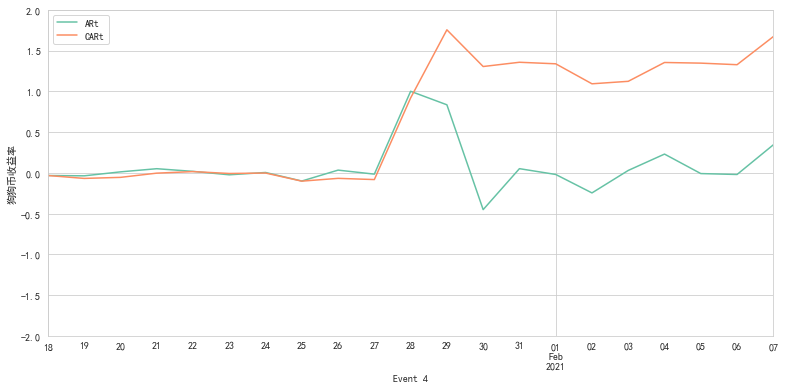

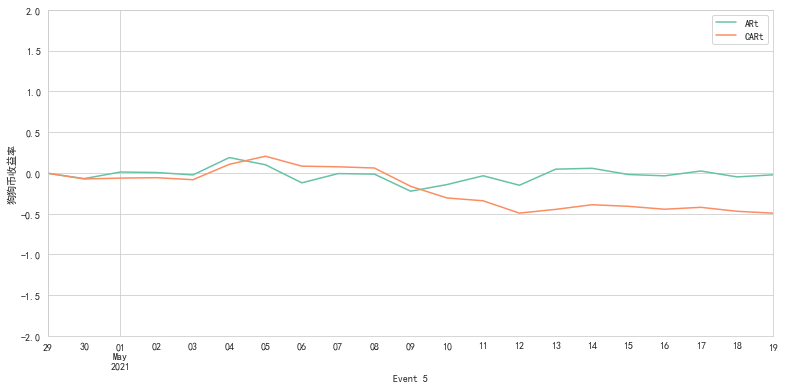

In [145]:
main(events)

In [139]:
a = get_data(events[0])

事件日为:  2021-01-28
构建模型，R2为22.24%
y = 0.006 + 1.566Rm 
t= 1.1468609775773955 p_twoTail= 0.2649747833170701 p_oneTail =  0.13248739165853504
接受零假设，没有统计显著，也就是事件未带来异常收益
    trade_date    狗狗币收益率  数字货币市场收益率     E(Rt)       ARt      CARt
147 2021-01-18  0.004408   0.019556  0.036210 -0.031802 -0.031802
148 2021-01-19  0.020640   0.032356  0.056252 -0.035612 -0.067413
149 2021-01-20 -0.054683  -0.046742 -0.067596  0.012912 -0.054501
150 2021-01-21 -0.029559  -0.055464 -0.081253  0.051694 -0.002807
151 2021-01-22 -0.047545  -0.046079 -0.066558  0.019013  0.016206
152 2021-01-23  0.050594   0.043506  0.073710 -0.023116 -0.006910
153 2021-01-24  0.016439   0.003463  0.011013  0.005426 -0.001484
154 2021-01-25 -0.021439   0.046280  0.078053 -0.099493 -0.100977
155 2021-01-26 -0.040763  -0.051518 -0.075075  0.034312 -0.066665
156 2021-01-27 -0.056947  -0.030468 -0.042115 -0.014832 -0.081496
157 2021-01-28  1.060428   0.034311  0.059313  1.001114  0.919618
158 2021-01-29  0.975838   0.086108  0.1404

# 进行T检验

In [18]:
!pip install scipy numpy
from scipy import stats

In [19]:
stats.ttest_1samp(a['ARt'],0)

Ttest_1sampResult(statistic=-0.36762428101372113, pvalue=0.7170150563073734)

In [20]:
a['ARt']

152   -0.012876
153   -0.026823
154   -0.012969
155   -0.008621
156    0.005610
157    0.004555
158   -0.000488
159   -0.003011
160   -0.009436
161   -0.043705
162   -0.011904
163   -0.024133
164   -0.012422
165    0.000538
166    0.003227
167   -0.011857
168    0.036648
169    0.029883
170    0.002481
171    0.033469
172    0.027549
Name: ARt, dtype: float64